In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from collections import Counter
from scipy.stats import entropy
from tqdm.notebook import tqdm

In [3]:
LIB_SIZE = 5021
ATOMS = ("I", "Br", "Cl", "S", "P", "F", "O", "N", "C", "H")

In [4]:
pnps = []

with open('pnpdatabase/pnp_AAGraphs1.txt', 'r') as f:
    for pnp_id in range(LIB_SIZE):
        filename, pnp_name = f.readline().split()
        _, _, pnp_formula, _, _, pnp_mass = f.readline().split()
        pnp_mass = float(pnp_mass)
        _ = f.readline()
        *_, pnp_size = f.readline().split()
        pnp_size = int(pnp_size)
        
        pnp = nx.MultiGraph(file=filename, name=pnp_name, formula=pnp_formula, mass=pnp_mass)
        
        for _ in range(pnp_size):
            AA_num, AA_formula, AA_mass = f.readline().split()
            AA_num = int(AA_num)
            AA_mass = float(AA_mass)
            pnp.add_node(AA_num, formula=AA_formula, mass=AA_mass)
        
        *_, edge_num = f.readline().split()
        edge_num = int(edge_num)
        pnp_multiedges = False
        
        for _ in range(edge_num):
            v1, _, v2 = f.readline().split()
            v1, v2 = int(v1), int(v2)
            if (v1 != v2):
                if (v1, v2) in pnp.edges:
                    pnp_multiedges = True
                pnp.add_edge(v1, v2)
        
        pnp.graph['multiedges'] = pnp_multiedges
        
        pnp_structure = f.readline().strip()
        pnp.graph['structure'] = pnp_structure
        
        pnps.append(pnp)


In [5]:
for pnp_id1 in range(LIB_SIZE):
    for pnp_id2 in range(LIB_SIZE):
        if (pnp_id1 == pnp_id2):
            continue
        


Element: I
Max in one AA: 1
Total: 15


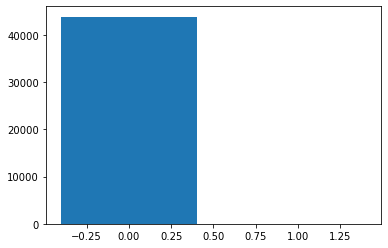

[(0, 43868), (1, 15)]

Element: Br
Max in one AA: 2
Total: 95


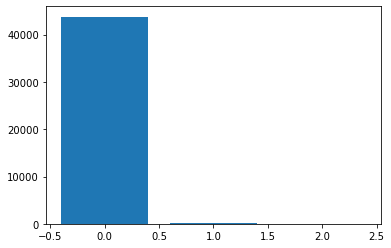

[(0, 43790), (1, 91), (2, 2)]

Element: Cl
Max in one AA: 3
Total: 593


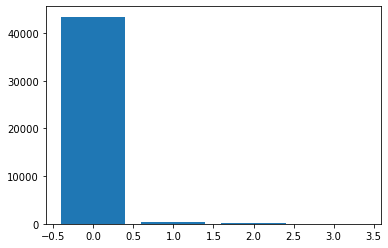

[(0, 43451), (1, 287), (2, 129), (3, 16)]

Element: S
Max in one AA: 6
Total: 2035


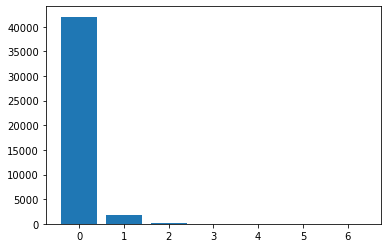

[(0, 42034), (1, 1687), (2, 148), (4, 7), (3, 6), (6, 1)]

Element: P
Max in one AA: 2
Total: 27


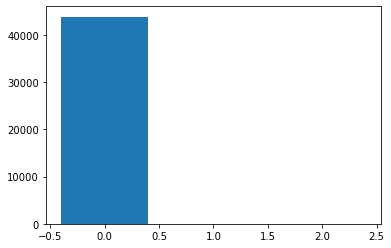

[(0, 43858), (1, 23), (2, 2)]

Element: F
Max in one AA: 1
Total: 13


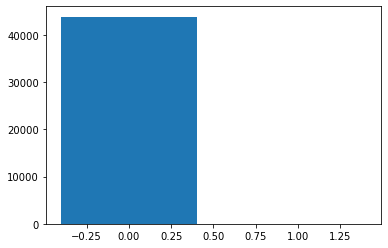

[(0, 43870), (1, 13)]

Element: O
Max in one AA: 28
Total: 71742


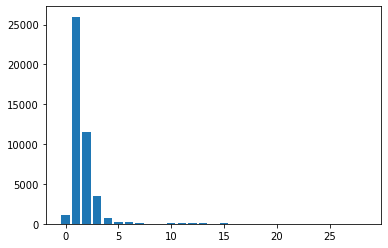

[(1, 25984), (2, 11549), (3, 3522), (0, 1053), (4, 734), (5, 263), (6, 213), (12, 113), (10, 76), (7, 73), (15, 58), (11, 58), (13, 55), (9, 36), (8, 34), (17, 16), (19, 13), (18, 10), (14, 8), (22, 6), (20, 5), (16, 3), (28, 1)]

Element: N
Max in one AA: 10
Total: 52122


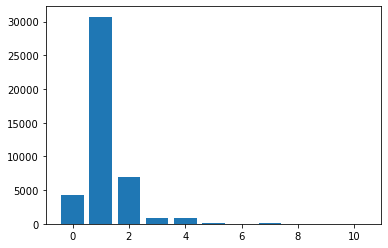

[(1, 30722), (2, 6993), (0, 4241), (4, 925), (3, 788), (7, 117), (5, 70), (6, 22), (10, 4), (9, 1)]

Element: C
Max in one AA: 59
Total: 253434


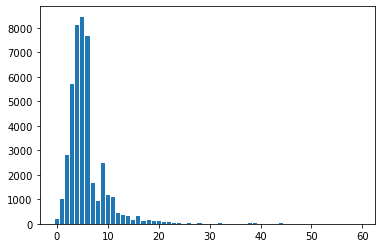

[(5, 8460), (4, 8109), (6, 7681), (3, 5728), (2, 2793), (9, 2481), (7, 1675), (10, 1194), (11, 1081), (1, 1000), (8, 916), (12, 447), (13, 374), (16, 326), (14, 325), (0, 215), (15, 172), (18, 151), (17, 127), (20, 110), (19, 101), (21, 76), (22, 74), (32, 43), (26, 32), (23, 29), (39, 21), (38, 20), (44, 19), (24, 16), (28, 13), (31, 10), (45, 9), (46, 7), (50, 6), (29, 6), (27, 6), (25, 5), (33, 5), (34, 3), (41, 3), (40, 3), (30, 2), (42, 2), (49, 2), (36, 1), (48, 1), (55, 1), (59, 1), (51, 1)]

Element: H
Max in one AA: 86
Total: 379533


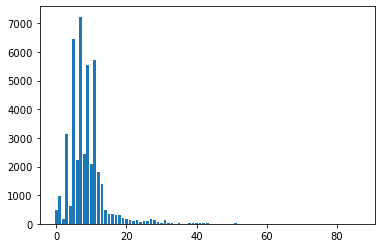

[(7, 7232), (5, 6457), (11, 5709), (9, 5541), (3, 3135), (8, 2423), (6, 2217), (10, 2071), (12, 1798), (13, 1406), (1, 974), (4, 634), (0, 491), (14, 469), (15, 356), (16, 346), (18, 304), (17, 295), (19, 220), (2, 181), (20, 162), (27, 152), (21, 149), (31, 148), (23, 134), (28, 119), (26, 111), (22, 94), (25, 87), (24, 74), (29, 69), (30, 41), (32, 41), (33, 35), (35, 22), (40, 16), (38, 16), (41, 14), (51, 14), (39, 13), (42, 13), (43, 11), (36, 10), (50, 9), (34, 8), (52, 7), (54, 6), (62, 6), (44, 5), (46, 5), (37, 5), (53, 4), (48, 3), (67, 3), (45, 3), (56, 2), (55, 2), (58, 2), (65, 2), (86, 2), (57, 1), (47, 1), (70, 1), (63, 1), (64, 1)]


In [7]:
atoms_distr = {}
for atom in ATOMS:
    atoms_distr[atom] = Counter()

init_atoms_in_aa = {atom: 0 for atom in ATOMS}

for pnp in pnps:
    for _ in pnp.nodes:
        aa = pnp.nodes[_]
        formula = aa['formula']
        atoms_in_aa = dict(init_atoms_in_aa)
        i, j, k = 0, 0, 0
        while i < len(formula):
            j = i + 1
            while j < len(formula) and formula[j].islower(): j += 1
            k = j
            while k < len(formula) and formula[k].isdigit(): k += 1
            atom = formula[i:j]
            if j == k:
                count = 1
            else:
                count = int(formula[j:k])
            atoms_in_aa[atom] += count;
            i = k
        for atom, count in atoms_in_aa.items():
            atoms_distr[atom].update([count])

for atom in atoms_distr.keys():
    c = atoms_distr[atom]
    total_num_of_atom = 0
    for key, value in c.items():
        total_num_of_atom += key * value
    
    print("\nElement:", atom)
    print("Max in one AA:", max(c.keys()))
    print("Total:", total_num_of_atom)
    plt.bar(c.keys(), c.values())
    plt.show()
    print(c.most_common())